Imports

In [2]:
"""Collection of general utility functions."""
import os
from typing import Tuple, Text, Dict, Union, Any

import numpy as np
from jax.experimental import sparse
from absl import logging
from jax import random, vmap, jit, grad, numpy as jnp
from jax.nn import softmax, relu
#from jax.ops import index_update, index DEPRECATED: replace with jax.numpy.ndarray.at in the corresponding code
from jax.scipy.linalg import expm
from scipy.optimize import minimize

Params = Tuple[jnp.ndarray, ...]
Results = Dict[Text, Union[jnp.ndarray, list, float]]
Tup = Tuple[float, float]



RESULT COLLECTION AND CHECKPOINTING

In [3]:
# =============================================================================
# RESULT COLLECTION AND CHECKPOINTING
# =============================================================================

def collect_results(params: Params) -> Results:
  """Create results dictionary from parameters at a given step.

  Args:
    params: The parameters to add to the results dictionary.

  Returns:
    results dictionary
  """
  results = {}
  weights, pos_spectrum, neg_spectrum, block_ul, block_ur = params
  results['weights'] = softmax(weights)
  spectra = make_spectra(pos_spectrum, neg_spectrum)
  results['spectra'] = spectra
  results['hamiltonian'] = make_hamiltonian(block_ul, block_ur)
  results['avg_neg_spec'] = jnp.mean(spectra[:, 1])
  results['avg_pos_spec'] = jnp.mean(spectra[:, 0])
  results['xs'] = make_xs(results['spectra'], results['hamiltonian'])
  return {k: np.array(v) for k, v in results.items()}


def write_checkpoint(params: Params,
                     name: Text,
                     out_dir: Text,
                     results: Dict = None) -> None:
  """Checkpoint current optimization parameters.

  Args:
    params: The current parameter tuple.
    name: The name under which to store the parameter checkpoint.
    out_dir: The directory where to store the parameters.
    results: If this result dictionary is not `None`, add the parameters (in
        their interpretable form) to the result dictionary and store this as
        in the same directory as `results.npz`.
  """
  result_path = os.path.join(out_dir, f"{name}.npz")
  weights, pos_spectrum, neg_spectrum, block_ul, block_ur = params
  np.savez(result_path, weights=weights, pos_spectrum=pos_spectrum,
           neg_spectrum=neg_spectrum, block_ul=block_ul, block_ur=block_ur)
  if results is not None:
    results.update(collect_results(params))
    result_path = os.path.join(out_dir, "results.npz")
    np.savez(result_path, **results)


Intialise

In [4]:
def init_params(key: jnp.ndarray, n: int, f: int, m: int,
                sigma_weights: float = 0, init_spectrum: float = 1,
                sigma_spectrum: float = 0) -> Params:
  """Initialize optimization parameters.

  Args:
    key: The random key.
    n: The spin dimension.
    f: The number of particles.
    m: The cardinality of the support of the discrete measure.
    sigma_weights: The standard deviation of the noise to be added to the fixed
      initialization of weights.
    init_spectrum: The initial absolute value of the mean of the negative
      eigenvalues. We will add 1/n to this value for each of the positive
      eigenvalues to ensure trace = 1.
    sigma_spectrum: The standard deviation of the noise to be added to the fixed
      initialization of the spectra.

  Returns:
    a 5-tuple of initial parameters:
        weights: The weights of the discrete measure (m,); real
        pos_spectrum: initial log values of pos spectrum (m, n); real
        neg_spectrum: initial log values of pos spectrum (m, n); real
        block_ul: the upper left block of H (m, 2n, 2n); complex
        block_ur: the upper right block of H (m, 2n, f - 2n); complex
  """
  subkeys = random.split(key, 7)
  weights = sigma_weights * random.normal(subkeys[0], (m,))
  # Initial pos spectra are all (init_spectrum + 1 / n) and
  # negative ones are all (init_spectrum)
  # We work with logs of desired spectra to ensure the correct signs later
  pos_spectrum = jnp.log(init_spectrum + 1. / n)
  pos_spectrum += sigma_spectrum * random.normal(subkeys[1], (m, n))
  neg_spectrum = jnp.log(init_spectrum)
  neg_spectrum += sigma_spectrum * random.normal(subkeys[2], (m, n))
  # Upper right block of Hermitian uniformly at random from
  # \{x + i y | -pi \le x, y \le pi \}
  # Compute lower left as conjugate transpose
  block_ur = random.uniform(subkeys[3], (m, 2 * n, f - 2 * n),
                            minval=-jnp.pi, maxval=jnp.pi)
  block_ur += 1J * random.uniform(subkeys[4], (m, 2 * n, f - 2 * n),
                                  minval=-jnp.pi, maxval=jnp.pi)
  # Upper left block paramaterized as block_ul + block_ul^{\dagger}
  # will set diagonal to zero explicitly
  block_ul = random.uniform(subkeys[5], (m, 2 * n, 2 * n),
                            minval=-jnp.pi, maxval=jnp.pi)
  block_ul += 1J * random.uniform(subkeys[6], (m, 2 * n, 2 * n),
                                  minval=-jnp.pi, maxval=jnp.pi)
  return weights, pos_spectrum, neg_spectrum, block_ul, block_ur

Make Hamiltonian

In [5]:
def make_hamiltonian(block_ul: jnp.ndarray,
                     block_ur: jnp.ndarray) -> jnp.ndarray:
  """Put together the full Hamiltonian from blocks.

  We ensure that Hamiltonians H are hermitian.
  Thereby, - i H are anti-hermitian and exp(-i H) is unitary.

  Args:
    block_ul: The upper left block is of shape (m, 2n, 2n)
    block_ur: The upper right block is of shape (m, 2n, f - 2n)

  Returns:
    The stack of full Hamiltonians of shape (m, f, f)
  """
  m = block_ul.shape[0]
  two_n = block_ul.shape[-1]
  f = block_ur.shape[-1] + two_n
  # compute upper left block as A + A^{\dagger} and set diag to 0
  block_ul = block_ul + jnp.swapaxes(jnp.conj(block_ul), 1, 2)
  block_ul *= (1 - jnp.eye(two_n)[jnp.newaxis, ...])
  # put pieces together
  hamiltonian = jnp.zeros((m, f, f), dtype=jnp.complex64)
  hamiltonian = hamiltonian.at[:, :two_n, :two_n].set(block_ul)
  hamiltonian = hamiltonian.at[:, :two_n, two_n:].set(block_ur)
  block_ur = jnp.swapaxes(jnp.conj(block_ur), 1, 2)
  hamiltonian = hamiltonian.at[:, two_n:, :two_n].set(block_ur)
  return hamiltonian

Make spectra

In [6]:
def make_spectra(pos_spectrum: jnp.ndarray,
                 neg_spectrum: jnp.ndarray) -> jnp.ndarray:
  """Compute actual spectra from optimization parameters.

  The spectra have to have n positive and n negative eigenvalues
  and satisfy the trace constraint, which we ensure here.

  Args:
    pos_spectrum: Optimization parameters for positive eigenvalues.
    neg_spectrum: Optimization parameters for negative eigenvalues.

  Returns:
    Full (m, 2 n) array of the m spectra
  """
  spectra = jnp.concatenate((jnp.exp(pos_spectrum), - jnp.exp(neg_spectrum)), 1)
  return spectra / jnp.sum(spectra, axis=1)[..., jnp.newaxis]

Action

In [7]:
def make_xs(spectra: jnp.ndarray, hamiltonian: jnp.ndarray) -> jnp.ndarray:
  """Generate the m spacetime points.

  Args:
    spectra: The spectra of the m points.
    hamiltonian: The Hamiltonian matrices.

  Returns:
    (m, f, f) stack of m spacetime points
  """
  m, two_n = spectra.shape
  f = hamiltonian.shape[-1]
  # (m, f, f), unitary <- expm(anti-hermitian)
  unitary = vmap(expm)(- 1J * hamiltonian)
  # (m, f)
  xs = vmap(jnp.diag)(jnp.concatenate((spectra, jnp.zeros((m, f - two_n))), 1))
  # (m, f, f), hermitian (U_i x_i U_i^{\dagger})
  xs = jnp.einsum('...ij,...jk,...lk->...il', unitary, xs, jnp.conj(unitary))
  return xs


def make_xs_and_weights(params: Params) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Get the spacetime points from the current parameters.

  Args:
    params: The tuple of parameters (weights, positive spectrum,
        negative spectrum, block_ul, block_ur).

  Returns:
    (m, f, f) array with a stack of m spacetime points of dimensions (f, f)
  """
  # (m, n), (m, n), (m, 2n, 2n), (m, 2n, f - 2n)
  weights, pos_spectrum, neg_spectrum, block_ul, block_ur = params
  # Scale weights into [0,1] and sum to 1
  weights = softmax(weights)
  # (m, 2n)
  spectra = make_spectra(pos_spectrum, neg_spectrum)
  # (m, f, f), hermitian
  hamiltonian = make_hamiltonian(block_ul, block_ur)
  # (m, f, f), hermitian
  return make_xs(spectra, hamiltonian), weights


def make_lagrangian_n(xs: jnp.ndarray, i: int, j: int, two_n: int) -> float:
  """The Lagrangian for a single pair of spacetime points for n >= 1.

  Args:
    xs: (m, f, f) array of all the spacetime points.
    i: Index for first point.
    j: Index for second point.
    two_n: 2n (2 times the spin dimension)

  Returns:
    value of the Lagrangian
  """
  xij = xs[i] @ xs[j]
  spec = jnp.sort(jnp.abs(jnp.linalg.eigvals(xij)))[-two_n:]
  bnd = jnp.sum(spec) ** 2
  return jnp.sum(spec ** 2) - bnd / two_n


def make_lagrangian_1(xs: jnp.ndarray, i: int, j: int, two_n: int) -> float:
  """The Lagrangian for a single pair of spacetime points for n = 1.

  Args:
    xs: (m, f, f) array of all the spacetime points.
    i: Index for first point.
    j: Index for second point.
    two_n: 2n (2 times the spin dimension); unused here, kept for compatibility.

  Returns:
    value of the Lagrangian
  """
  xij = xs[i] @ xs[j]
  tmp = jnp.real(jnp.trace(xij) ** 2)
  return relu(jnp.real(jnp.trace(xij @ xij)) - tmp / 2.)


def action(params: Params) -> float:
  """The action.

  Args:
    params: The 5-tuple of parameters (weights, positive spectrum,
        negative spectrum, block_ul, block_ur).

  Returns:
    single float for the value of the action
  """
  xs, weights = make_xs_and_weights(params)
  # weighted sum of Lagrangian for pairs
  m, two_n, _ = params[-2].shape
  if two_n == 2:
    make_lag = vmap(make_lagrangian_1, (None, 0, 0, None))
  else:
    make_lag = vmap(make_lagrangian_n, (None, 0, 0, None))
  # Only looking at upper triangle (without diagonal)
  rows, cols = jnp.triu_indices(m, k=1)
  lag_ij = make_lag(xs, rows, cols, two_n)
  act = 2 * jnp.sum(weights[rows] * weights[cols] * lag_ij)
  # Add diagonal
  diag = jnp.arange(m)
  lag_ij = make_lag(xs, diag, diag, two_n)
  act += jnp.sum(weights ** 2 * lag_ij)
  return act


def boundedness(params: Params) -> float:
  """The boundedness functional.

  Args:
    params: The 5-tuple of parameters (weights, positive spectrum,
        negative spectrum, block_ul, block_ur).

  Returns:
    single float for the value of the action
  """
  xs, weights = make_xs_and_weights(params)
  # weighted sum of Lagrangian for pairs
  m, two_n, _ = params[-2].shape

  def _boundedness(_xs, _i, _j, _two_n):
    xij = _xs[_i] @ _xs[_j]
    spec = jnp.sort(jnp.abs(jnp.linalg.eigvals(xij)))[-_two_n:]
    _bnd = jnp.sum(spec) ** 2
    return _bnd

  make_bnd = vmap(_boundedness, (None, 0, 0, None))
  # Only looking at upper triangle (without diagonal)
  rows, cols = jnp.triu_indices(m, k=1)
  bnd_ij, _ = make_bnd(xs, rows, cols, two_n)
  bnd = 2 * jnp.sum(weights[rows] * weights[cols] * bnd_ij)
  # Add diagonal
  diag = jnp.arange(m)
  bnd_ij, _ = make_bnd(xs, diag, diag, two_n)
  bnd += jnp.sum(weights ** 2 * bnd_ij)
  return bnd


# =============================================================================
# OPTIMIZATION
# =============================================================================

def _flatten_params(params: Params) -> jnp.ndarray:
  """Flatten all (complex) optimization parameters into single (real) vector."""
  all_params = []
  for p in params:
    if p.dtype in [jnp.float32, jnp.float64]:
      all_params.append(p.ravel())
    else:
      all_params.append(jnp.real(p.ravel()))
      all_params.append(jnp.imag(p.ravel()))
  return jnp.concatenate(all_params)


def _reconstruct_params(params: jnp.ndarray, n: int, f: int, m: int) -> Params:
  """Rearrange parameters into original shape from flat (real) vector.

  Returns:
    a 5-tuple of initial parameters:
        weights: The weights of the discrete measure (m,); real
        pos_spectrum: initial log values of pos spectrum (m, n); real
        neg_spectrum: initial log values of pos spectrum (m, n); real
        block_ul: the upper left block of H (m, 2n, 2n); complex
        block_ur: the upper right block of H (m, 2n, f - 2n); complex
  """
  n_w = m
  n_pos = n_w + n * m
  n_neg = n_pos + n * m
  n_ul_r = n_neg + m * 4 * n ** 2
  n_ul_i = n_ul_r + m * 4 * n ** 2
  n_ur_r = n_ul_i + m * 2 * n * (f - 2 * n)
  splits = [n_w, n_pos, n_neg, n_ul_r, n_ul_i, n_ur_r]
  (weights,
   pos_spectrum,
   neg_spectrum,
   block_ul_r,
   block_ul_i,
   block_ur_r,
   block_ur_i) = jnp.split(params, splits)
  pos_spectrum = pos_spectrum.reshape(m, n)
  neg_spectrum = neg_spectrum.reshape(m, n)
  block_ul = (block_ul_r + 1J * block_ul_i).reshape(m, 2 * n, 2 * n)
  block_ur = (block_ur_r + 1J * block_ur_i).reshape(m, 2 * n, f - 2 * n)
  return weights, pos_spectrum, neg_spectrum, block_ul, block_ur


def _action_flat_params(params: jnp.ndarray, n: int, f: int, m: int) -> float:
  """Action computation for bfgs optimization."""
  params = _reconstruct_params(params, n, f, m)
  return action(params)

In [8]:
#initialise parameters

sigma_weights = 0.01
sigma_spectrum = 0.01
lbfgs_maxiter = 10000
lbfgs_gtol = 1e-7
lbfgs_ftol = 1e-9
lbfgs_maxcor = 70
lbfgs_maxls = 20
bfgs_maxiter = 5000
bfgs_gtol = 1e-7
max_m_bfgs = 1000
seed = 543

key = random.PRNGKey(seed)

In [9]:
def n1_f2_neg_spectrum_from_m(m):
  """In the n=1, f=2 scenario, get the abs value of the neg eigenvalue at opt
  for 2-dim sphere.

  For the case n=1, f=2 *without* the boundedness constraint, the optimal
  solution is to send pos and neg eigenvalues to pos / neg infinity as m goes to
  infinity.
  We can compute these values for the positive and negative eigenvalues
  analytically.

  Returns:
    the absolute value of the negative eigenvalue at the optimum.
  """
  return (3 ** (1. / 4.) * jnp.sqrt(m / (2 * jnp.pi)) - 1.) / 4

optimise

In [10]:
def optimize(params: Params,
             n: int,
             f: int,
             m: int,
             lbfgs_options: Dict[Text, Any],
             bfgs_options: Dict[Text, Any],
             ) -> Tuple[Params, Results]:
  """Wrapper around the scipy BFGS minimizer that also collects results.

  Args:
    params: The tuple of optimization parameters.
    n: The desired spin dimension.
    f: The desired number of particles.
    m: The desired cardinality of the support of the discrete measure.
    lbfgs_options: The options to pass to L-BFGS. If the argument is None or the
        maxiter option is 0, don't run L-BFGS at all.
    bfgs_options: The options to pass to BFGS. If the argument is None or the
        maxiter option is 0, don't run BFGS at all.
  """

  if ((bfgs_options is None or bfgs_options['maxiter'] <= 0) and
      (lbfgs_options is None or lbfgs_options['maxiter'] <= 0)):
    raise ValueError("Run either bfgs or lbfgs for at least 1 iteration.")

  results = {
    'action': [],
    'boundedness': [],
    # 'n_iterations': [],
    'n': n,
    'f': f,
    'm': m
  }
  first_iteration_time = None
  iteration_counter = 0
  def callback_function(xk):
      nonlocal first_iteration_time, iteration_counter
      iteration_counter += 1  # Increment the counter
      if iteration_counter == 1:  # Check if it's the first iteration
          first_iteration_time = time.time() - start_time  # Calculate the time taken


  # ---------------------------------------------------------------------------
  # Initialization and setup
  # ---------------------------------------------------------------------------
  params0 = _flatten_params(params)

  # ---------------------------------------------------------------------------
  # L-BFGS (scipy)
  # ---------------------------------------------------------------------------
  start_time = time.time()

  f_act = jit(_action_flat_params, static_argnums=(1, 2, 3))
  func_grad = jit(grad(_action_flat_params), static_argnums=(1, 2, 3))
  g_act = lambda x, _n, _f, _m: np.array(func_grad(x, _n, _f, _m))
  res = None
  if lbfgs_options is not None and lbfgs_options['maxiter'] > 0:
    res = minimize(f_act, params0, args=(n, f, m), method="l-bfgs-b", jac=g_act, options=lbfgs_options, callback=callback_function)
    #results = _log_and_update_results("LBFGS", res, results)

  # ---------------------------------------------------------------------------
  # BFGS scipy
  # ---------------------------------------------------------------------------
  if bfgs_options is not None and bfgs_options['maxiter'] > 0:
    if res is not None:
      params0 = res.x
    res = minimize(f_act, params0, args=(n, f, m), method="bfgs", jac=g_act, options=bfgs_options, callback=callback_function)
  #results = _log_and_update_results("BFGS", res, results)

  # ---------------------------------------------------------------------------
  # Final results reporting
  # ---------------------------------------------------------------------------
  final_params = _reconstruct_params(res.x, n, f, m)
  act = action(final_params)
  #bnd = boundedness(final_params)
  results['action'].append(act)
  #results['boundedness'].append(bnd)
  return final_params, {k: np.array(v) for k, v in results.items()},first_iteration_time


In [11]:
# ---------------------------------------------------------------------------
# Optimization and writing results
# ---------------------------------------------------------------------------
#n = 1, f = 2

import matplotlib.pyplot as plt

def main(n,f,m_sweep):

  # Parameter and result initialization
  # ---------------------------------------------------------------------------
  key2, subkey = random.split(key)

  # Setup (L)BFGS options
  # ---------------------------------------------------------------------------

  def make_options(m):
    lbfgs_options = {
      "maxiter": lbfgs_maxiter,
      "maxfun": 2 * lbfgs_maxiter,
      "disp": 50,
      "gtol": lbfgs_gtol,
      "ftol": lbfgs_ftol,
      "maxcor": lbfgs_maxcor,
      "maxls": lbfgs_maxls,
    }

    if max_m_bfgs < m:
      bfgs_options = None
    else:
      bfgs_options = {
        "maxiter": bfgs_maxiter,
        "disp": True,
        "gtol": bfgs_gtol,
      }
    return lbfgs_options,bfgs_options


  actions = []

  for m in m_sweep:
    lbfgs_options,bfgs_options = make_options(m)

    init_spectrum = 5*n1_f2_neg_spectrum_from_m(m)

    params_0 = init_params(subkey, n, f, m,
                            sigma_weights, init_spectrum,
                            sigma_spectrum)

    final_params, bfgs_res = optimize(
    params_0, n, f, m, lbfgs_options, bfgs_options)

    actions.append(bfgs_res["action"])

  plt.scatter(m_sweep,actions)

  plt.show()



In [12]:
# ---------------------------------------------------------------------------
# Measure running time
# ---------------------------------------------------------------------------
#n = 1, f = 2
import time
import matplotlib.pyplot as plt

def measure_single_time(key,n,f,m):

  # Parameter and result initialization
  # ---------------------------------------------------------------------------
  key2, subkey = random.split(key)

  # Setup (L)BFGS options
  # ---------------------------------------------------------------------------

  def make_options(m):
    lbfgs_options = {
      "maxiter": lbfgs_maxiter,
      "maxfun": 2 * lbfgs_maxiter,
      "disp": 50,
      "gtol": lbfgs_gtol,
      "ftol": lbfgs_ftol,
      "maxcor": lbfgs_maxcor,
      "maxls": lbfgs_maxls,
    }

    bfgs_options = {
        "maxiter": bfgs_maxiter,
        "disp": True,
        "gtol": bfgs_gtol,
      }
    return lbfgs_options,bfgs_options

  lbfgs_options,bfgs_options = make_options(m)

  init_spectrum = 5*n1_f2_neg_spectrum_from_m(m)

  params_0 = init_params(subkey, n, f, m,
                          sigma_weights, init_spectrum,
                          sigma_spectrum)
  #measure time

  start_time = time.time()
  final_params, bfgs_res, first_optimisation_time = optimize(
  params_0, n, f, m, lbfgs_options, bfgs_options)
  end_time = time.time()
  elapsed_time = end_time - start_time

  return elapsed_time, first_optimisation_time




/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.166444
         Iterations: 1
         Function evaluations: 59
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.157918
         Iterations: 0
         Function evaluations: 51
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.146385
         Iterations: 0
         Function evaluations: 57
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.050000
         Iterations: 0
         Function evaluations: 59
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.050000
         Iterations: 0
         Function evaluations: 66
         Gradient evaluations: 55


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.050000
         Iterations: 0
         Function evaluations: 66
         Gradient evaluations: 54


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.033335
         Iterations: 0
         Function evaluations: 74
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.020223
         Iterations: 0
         Function evaluations: 76
         Gradient evaluations: 65


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.014253
         Iterations: 0
         Function evaluations: 76
         Gradient evaluations: 64


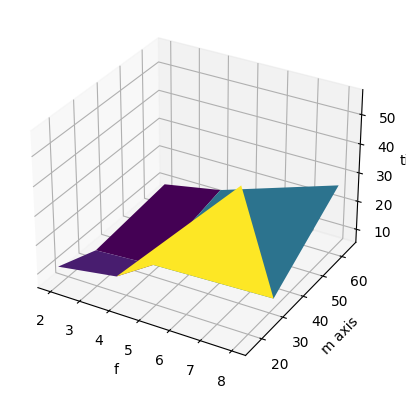

In [13]:
f_array = np.array([2,4,8])
m_array = np.array([16,32,64])

elapsed_times = np.zeros((len(m_array),len(f_array)))
first_optimisation_times = np.zeros((len(m_array),len(f_array)))

for i in np.arange(len(m_array)):
  for j in np.arange(len(f_array)):
    f = f_array[i]
    m = m_array[j]
    elapsed_times[i,j],first_optimisation_times[i,j] = measure_single_time(key,1,f,m)



from mpl_toolkits.mplot3d import Axes3D
X, Y = np.meshgrid(f_array, m_array)

Z = elapsed_times

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels
ax.set_xlabel('f')
ax.set_ylabel('m axis')
ax.set_zlabel('time')

# Show the plot
plt.show()

In [14]:
print("total_times:", elapsed_times)
print("first compilation time:", first_optimisation_times)
print("total_time/first_time: ", elapsed_times/first_optimisation_times)
A = [[(m_array[i], f_array[j]) for j in range(len(f_array))]for i in range(len(m_array))]
print("parameters:", A)

total_times: [[11.66071367 14.75662136 57.3273921 ]
 [ 6.35590792  7.52259898  8.84311676]
 [ 9.22421026 13.02777004 26.58713984]]
first compilation time: [[5.20887518 4.3785665  5.49111128]
 [4.9354012  5.82814574 5.24224997]
 [6.48149514 7.98070765 8.14682293]]
total_time/first_time:  [[ 2.23862413  3.37019464 10.44003467]
 [ 1.28781991  1.29073625  1.68689338]
 [ 1.42316087  1.63240788  3.26349794]]
parameters: [[(16, 2), (16, 4), (16, 8)], [(32, 2), (32, 4), (32, 8)], [(64, 2), (64, 4), (64, 8)]]


vectoriser mes fonctions  dans action avant de run